# Quantitative MRI: Confounding Factors, Bias, and Reproducibility


## Fat quantification signal model (R2*-uncorrected): 

<font size="4">

<br>

$s(TE) = \left( A_{\hbox{water}} + A_{\hbox{fat}} \sum_{p=1}^P \rho_p e^{i 2 \pi TE f_p} \right) $

**Known parameters**: TE values (say, 6 echo times), $\rho_p$ and $f_p$ (fat NMR peak relative amplitudes and frequencies)


**Unknown parameters**: $A_{\hbox{water}}$, $A_{\hbox{fat}}$

**Fat quantification**: Fat fraction in percentage (FF) = $100 \cdot A_{\hbox{fat}} / (A_{\hbox{fat}} + A_{\hbox{water}})$

    
<br>
    
</font>
    
    
## Fat quantification signal model (R2*-corrected): 


<font size="4">

<br>

$s(TE) = \left( A_{\hbox{water}} + A_{\hbox{fat}} \sum_{p=1}^P \rho_p e^{i 2 \pi TE f_p} \right)$ <font color='red'> **$e^{-  TE \, R_2^* }$** </font>

**Known parameters**: TE values (say, 6 echo times), $\rho_p$ and $f_p$ (fat NMR peak relative amplitudes and frequencies)


**Unknown parameters**: $A_{\hbox{water}}$, $A_{\hbox{fat}}$, <font color='red'>**$R_2^*$**</font>

**Fat quantification**: Fat fraction in percentage (FF) = $100 \cdot A_{\hbox{fat}} / (A_{\hbox{fat}} + A_{\hbox{water}})$

</font>


In [17]:
## MP 710: Quantitative MRI
##
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
import scipy.io as sio
from dataclasses import dataclass
from scipy.optimize import curve_fit
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [18]:
@dataclass
class trueParams: # Tissue parameters to simulate chemical shift encoded signal
    A: float
    ff: float
    r2star: float
    fieldmap: float = 0.0
        
@dataclass
class imDataParams: # Acquisition parameters to simulate chemical shift encoded signal
    FieldStrength: float
    TE: list
        

@dataclass
class algoParams: # Specifies signal model for chemical shift encoded signal
    fatFreqs: list
    fatAmps: list
    USE_R2: bool    
        

# This function synthetizes some CSE signal given tissue, acquisition, and signal model        
def create_signal(imP, trueP, algoP):
    sw = trueP.A*(1-trueP.ff*0.01)*np.ones(len(imP.TE))
    sf = 0*imP.TE
    
    for n in range(0, len(algoP.fatFreqs)):
        sf = sf + algoP.fatAmps[n]*trueP.A*trueP.ff*0.01*np.exp(1j*2*np.pi*imP.TE*algoP.fatFreqs[n]*imP.FieldStrength*42.576)
        #sf = sf + imP.TE
    s = sw + sf
    
    if algoP.USE_R2:
        s = s*np.exp(-imP.TE*trueP.r2star + 1j*2*np.pi*imP.TE*trueP.fieldmap)
    else:
        s = s*np.exp(1j*2*np.pi*imP.TE*trueP.fieldmap)
    
    return s

# Wrapper for create_signal function above     
def create_signal_r2star(TE, A, ff, r2star):
    
    global myImDataParams
    global myAlgoParams
    
    fieldmap = 0
    myTrueParams = trueParams(A, ff, r2star,fieldmap)

    s = create_signal(myImDataParams, myTrueParams, myAlgoParams)
    
    s2 = np.abs(s)
    
    return s2

# Wrapper for create_signal function above, without including R2* in the model     
def create_signal_nor2star(TE, A, ff):
    
    global myImDataParams
    global myAlgoParams
    
    r2star = 0
    fieldmap = 0
    myTrueParams = trueParams(A, ff, r2star,fieldmap)

    s = create_signal(myImDataParams, myTrueParams, myAlgoParams)
    
    s2 = np.abs(s)
    
    return s2


# Make the fonts large
font = {'weight' : 'normal',
        'size'   : 20}

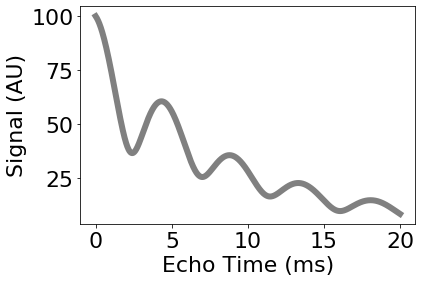

In [34]:
global myAlgoParams 
global myImDataParams
global t
global s1

# Set some parameters for plotting a continuous-looking CSE signal
N = 1001
tmax = 20*0.001
t = np.linspace(0.0,tmax,N)

# Set some true FF and R2* (can try different values but for this 
# exercise we will end up fixing them at 30.0 and 100.0, respectively)
true_FF = 30.0
true_R2star = 100.0

myTrueParams = trueParams(100., true_FF, true_R2star, 0.)

fFreq = [-3.80, -3.40, -2.60, -1.94, -0.39, 0.60];
fAmps = [0.087, 0.693, 0.128, 0.004, 0.039, 0.048];
myAlgoParams = algoParams(fFreq, fAmps, True )

myImDataParams = imDataParams(1.5, t)
s1 = create_signal(myImDataParams, myTrueParams , myAlgoParams);

plt.plot(t*1000,abs(s1),'gray',linewidth=6.0);
plt.xlabel('Echo Time (ms)');
plt.ylabel('Signal (AU)');
plt.rc('font', **font)


In [32]:
# Plot the least-squares signal fit given some echo time combination
def showFit(TE1,dTE):
    global myAlgoParams 
    global myImDataParams
    global t
    global s1
    
    font = {'weight' : 'normal',
        'size'   : 22}
        
    TE1 = TE1*0.001
    dTE = dTE*0.001
    nTE = 6
    TE = np.linspace(TE1,TE1 + (nTE-1)*dTE,nTE)
    myImDataParams = imDataParams(1.5, TE)
    s = create_signal(myImDataParams, myTrueParams , myAlgoParams);

    fFreq = [ -3.40];
    fAmps = [ 0.693];
    myAlgoParams = algoParams(fFreq, fAmps, True )

    p0 = np.array([90.,40.])
    popt, pcov = curve_fit(create_signal_nor2star, TE, abs(s), p0);
    sfit = create_signal_nor2star( TE, popt[0], popt[1])


    p0 = np.array([90.,40.,50.])
    popt2, pcov = curve_fit(create_signal_r2star, TE, abs(s), p0);
    sfit2 = create_signal_r2star( TE, popt2[0], popt2[1], popt2[2])

    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot(t*1000,abs(s1),'gray',linewidth=6.0);
    plt.plot(TE*1000,abs(s),'or',markersize=12);
    plt.plot(TE*1000,abs(sfit),'sg',markersize=9);
    plt.xlabel('Echo Time (ms)');
    plt.ylabel('Signal (AU)');
    plt.title('R2*-uncorrected: Estimated FF = ' '{:.3}'.format(popt[1]) );
    plt.rc('font', **font)

    plt.subplot(1,2,2)
    plt.plot(t*1000,abs(s1),'gray',linewidth=6.0);
    plt.plot(TE*1000,abs(s),'or',markersize=12);
    plt.plot(TE*1000,abs(sfit2),'sg',markersize=9);
    plt.xlabel('Echo Time (ms)');
    plt.ylabel('Signal (AU)');
    plt.title('R2*-corrected: Estimated FF = ' '{:.3}'.format(popt2[1]) );
    plt.rc('font', **font)

        

In [33]:
## Create interactive slide bar
y = interactive(showFit,TE1=(0.4,3.0,0.2),dTE=(0.6,4.0,0.2))
display(y)

interactive(children=(FloatSlider(value=1.6, description='TE1', max=3.0, min=0.4, step=0.2), FloatSlider(value…